# Derive models of spacecraft with star tracker

Do all imports.

In [2]:
import sympy as sym
import numpy as np
from IPython.display import display, Markdown
import ae353_spacecraft_design as design

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

## Create spacecraft

Create a visualizer to help with placement of reaction wheels.

In [3]:
# Create the visualizer
vis = design.create_visualizer()

# Show the visualizer in this notebook
vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


Specify the location of four reaction wheels in terms of their right ascension $\alpha$ and declination $\delta$. You cannot change the number of wheels, but it is likely that you **must** change the location of wheels in order for the system to be controllable.

In [4]:
wheels = [
    {'alpha': 1 * np.pi / 3, 'delta': np.pi / 6},
    {'alpha': 3 * np.pi / 3, 'delta': np.pi / 6},
    {'alpha': 5 * np.pi / 3, 'delta': np.pi / 6},
    {'alpha': 0, 'delta': - np.pi / 2},
]

Show wheels in the visualizer. You will be warned if any wheel obscures the star tracker (i.e., the "scope") or if any two wheels are too close together.

In [5]:
design.show_wheels(vis, wheels)

Create a model of the spacecraft in URDF format. This will **overwrite** the file `spacecraft.urdf` in the `urdf` directory. Also, compute the mass $m$ and inertia matrix $J$ of the spacecraft (including all the wheels). These parameters will be used later when deriving equations of motion.

In [6]:
m, J = design.create_spacecraft(wheels)

display(Markdown(
       r'$$'
    + fr'm = {sym.latex(np.round(m, decimals=2))}'
    +  r' \qquad\qquad '
    + fr'J = {sym.latex(sym.Matrix(J.round(decimals=2)))}'
    +  r'$$'
))

$$m = 19.0 \qquad\qquad J = \left[\begin{matrix}23.37 & 0.0 & 0.0\\0.0 & 23.37 & 0.0\\0.0 & 0.0 & 20.08\end{matrix}\right]$$

## Create stars

Specify the location of at most ten stars in terms of their right ascension $\alpha$ and declination $\delta$. It is likely that you **must** change the number and/or location of stars in order for the system to be observable.

In [7]:
stars = [
    {'alpha':  0.20, 'delta':  0.00}, # <-- To add a star, append a copy of this dict to the list. To change
                                      #     the location of a star, change the value of alpha and delta
    {'alpha':  0.10, 'delta':  0.00},
    {'alpha':  -0.20, 'delta':  0.00},
    {'alpha':  0.00, 'delta':  0.20},
    {'alpha':  0.00, 'delta':  -0.20},
]

Show where the stars will appear in the scope. The plot on the left shows $\alpha$ and $\delta$ gridelines. The plot on the right shows $y_\text{star}$ and $z_\text{star}$ gridlines.

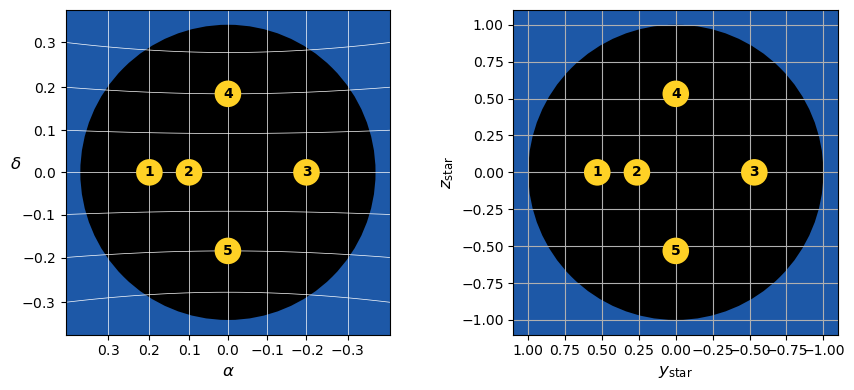

In [8]:
design.show_stars(stars)

Create a file with the location of stars. This will **overwrite** the file `stars.json` in the `urdf` directory.

In [9]:
design.create_stars(stars)

## Create dynamic model

Derive the equations of motion.

In [10]:
# Define yaw, pitch, roll angles
psi, theta, phi = sym.symbols('psi, theta, phi')

# Define angular velocities
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# Define torques
tau_1, tau_2, tau_3, tau_4 = sym.symbols('tau_1, tau_2, tau_3, tau_4')

# Compute resultant torques
T1 = - tau_1 * sym.Matrix(wheels[0]['xyz']) / np.linalg.norm(wheels[0]['xyz'])
T2 = - tau_2 * sym.Matrix(wheels[1]['xyz']) / np.linalg.norm(wheels[1]['xyz'])
T3 = - tau_3 * sym.Matrix(wheels[2]['xyz']) / np.linalg.norm(wheels[2]['xyz'])
T4 = - tau_4 * sym.Matrix(wheels[3]['xyz']) / np.linalg.norm(wheels[3]['xyz'])
T = sym.nsimplify(T1 + T2 + T3 + T4)

# Define rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])

# Define the transformation from angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# Define euler's equations
Jx, Jy, Jz = [sym.nsimplify(j) for j in np.diag(J)]
euler = sym.Matrix([[(1 / Jx) * (T[0] + (Jy - Jz) * w_y * w_z)],
                    [(1 / Jy) * (T[1] + (Jz - Jx) * w_z * w_x)],
                    [(1 / Jz) * (T[2] + (Jx - Jy) * w_x * w_y)]])

# Define equations of motion
f = sym.simplify(sym.Matrix.vstack(M * sym.Matrix([[w_x], [w_y], [w_z]]), euler), full=True)

The equations of motion have this form:

$$\begin{bmatrix} \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \\ \dot{w_x} \\ \dot{w_y} \\ \dot{w_z} \end{bmatrix} = f\left(\psi, \theta, \phi, w_x, w_y, w_z, \tau_1, \tau_2, \tau_3, \tau_4\right).$$

Here is the function $f$:

In [11]:
f

Matrix([
[                                                                                                                                                                             (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                                                                                                                                                                          w_y*cos(phi) - w_z*sin(phi)],
[                                                                                                                                                              w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[-433012701892219*tau_1/23367395830000000 + 866025403784439*tau_2/23367395830000000 - 433012701892219*tau_3/23367395830000000 - 612323399573677*tau_4/233673958300000000000000000000000 + 329052083*w_y*w_z/2336739583],
[                                                                       -75000000*tau_1/2336739583 - 106057523872491*tau_2/

## Create sensor model

Create symbolic variables for right ascension $\alpha$ and declination $\delta$ of each star.

In [12]:
alpha, delta = sym.symbols('alpha, delta')

Derive the sensor model for one star.

In [13]:
# Position of star in space frame
p_star_in_space = sym.Matrix([[sym.cos(alpha) * sym.cos(delta)],
                              [sym.sin(alpha) * sym.cos(delta)],
                              [sym.sin(delta)]])

# Orientation of body frame in space frame
R_body_in_space = Rz * Ry * Rx

# Position of star in body frame (assuming origin of body and space frames are the same)
p_star_in_body = R_body_in_space.T * p_star_in_space

# Position of star in image frame
r = sym.nsimplify(design.scope_radius)
p_star_in_image = (1 / r) * sym.Matrix([[p_star_in_body[1] / p_star_in_body[0]],
                                        [p_star_in_body[2] / p_star_in_body[0]]])

# Sensor model for each star
g = sym.simplify(p_star_in_image, full=True)

The sensor model has the following form:

$$\begin{bmatrix} y_\text{star} \\ z_\text{star} \end{bmatrix} = g(\psi, \theta, \phi, \alpha, \delta).$$

Here is the function $g$:

In [14]:
g

Matrix([
[21*(sin(delta)*sin(phi)*cos(theta) + sin(phi)*sin(theta)*cos(delta)*cos(alpha - psi) + sin(alpha - psi)*cos(delta)*cos(phi))/(8*(-sin(delta)*sin(theta) + cos(delta)*cos(theta)*cos(alpha - psi)))],
[21*(sin(delta)*cos(phi)*cos(theta) - sin(phi)*sin(alpha - psi)*cos(delta) + sin(theta)*cos(delta)*cos(phi)*cos(alpha - psi))/(8*(-sin(delta)*sin(theta) + cos(delta)*cos(theta)*cos(alpha - psi)))]])

Again, this sensor model is for **one star only**. You will have to use a copy of this same model for each star you defined in the "Create Stars" section of this notebook.

## Derive A and B

In [15]:
from scipy.linalg import solve_continuous_are
import numpy.linalg as la

best_params = (0.2682695795279725,0.2682695795279725,0.2682695795279725,0.2682695795279725)

m = (psi, theta, phi, w_x, w_y, w_z)
n = (tau_1, tau_2, tau_3, tau_4)
mn = (psi, theta, phi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4)

xd = f

An = sym.lambdify(mn, xd.jacobian(m))
Bn = sym.lambdify(mn, xd.jacobian(n))

# the satilite must be stationary and not be 
# applying any torque to stop the wheels from going to fast
A = An(0,0,0,0,0,0,0,0,0,0)
B = Bn(0,0,0,0,0,0,0,0,0,0)
print("Matrix A:")
print(A.tolist())
print("Matrix B:")
print(B.tolist())

Q = np.diag((50,50,50,1,1,1)) * best_params[0]
R = np.diag((1,1,1,1)) * best_params[1]

P = solve_continuous_are(A,B,Q,R)
K = la.inv(R) @ B.T @ P
print("Matrix K:")
print(K.tolist())

Matrix A:
[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 1.0, -0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, -0.0, 0.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Matrix B:
[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [-0.018530635807362836, 0.037061271614725715, -0.018530635807362836, -2.62041779934909e-18], [-0.032096002714907576, -4.538696765530462e-18, 0.032096002714907576, 0.0], [-0.0249042741960589, -0.0249042741960589, -0.0249042741960589, 0.0498085483921178]]
Matrix K:
[[-2.6726124191242517, -5.000000000000004, -2.8867513459481344, -7.217632087849548, -12.501305486494875, -5.550171449717585], [-2.67261241912425, -8.498609549814149e-15, 5.773502691896259, 14.435264175699114, -5.531005805371722e-15, -5.550171449717579], [-2.67261241912425, 5.0000000000000115, -2.88675134594812, -7.2176320878495535, 12.501305486494875, -5.550171449717582], [5.345224838248501, 6.894387940644665e-16, 1.5590659604934256e-15, 2.540591671

In [16]:
W = B

for i in range(B.shape[0] - 1):
    W = np.block([W, la.matrix_power(A, i + 1) @ B])

if W.shape[0] == la.matrix_rank(W):
    print("System is controllable.")
else:
    print("System is not controllable.")


System is controllable.


In [17]:
import numpy as np

g_all = []
for s in stars:
    g_i = g.subs({alpha: s['alpha'], delta: s['delta']})
    g_all.append(g_i)
h = sym.Matrix.vstack(*g_all)  # size 2N x 1

# Derivative w.r.t orientation part of state
x_sensor = sym.Matrix([psi, theta, phi])
C_h = h.jacobian(x_sensor)

# Evaluate at equilibrium (psi=theta=phi=0)
C_eq = C_h.subs({psi: 0, theta: 0, phi: 0})

# Convert to numpy function
C_func = sym.lambdify((), C_eq)
C_num = np.array(C_func(), dtype=np.float64)

# Pad with zeros to make it 2N x 6 (full state)
C = np.hstack((C_num, np.zeros((C_num.shape[0], 3))))

def lqr(A, B, Q, R):
    P = solve_continuous_are(A, B, Q, R)
    K = la.inv(R) @ B.T @ P
    return K

# Define weight matrices for LQR
Q0 = np.eye(C.shape[0]) * best_params[2]
R0 = np.eye(A.shape[0]) * best_params[3]

# O = C
# for i in range(C.shape[0] - 1):
#     O = np.block([W, C @ la.matrix_power(A, i + 1)])

# if O.shape[0] == la.matrix_rank(O):
#     print("System is observable.")
#     L = lqr(A.T, C.T, la.inv(R0), la.inv(Q0)).T
# else:
#     print("System is not observable, the rank is", la.matrix_rank(W))
#     L = lqr(A.T, C.T, la.inv(R0), la.inv(Q0)).T

L = lqr(A.T, C.T, la.inv(R0), la.inv(Q0)).T

print("Matrix L:")
print(L.tolist())
print("Matrix C:")
print(C.tolist())
#display(sym.Matrix(C))

Matrix L:
[[-0.5280192593161137, 4.827026059303848e-17, -0.5122843921038144, 4.3280728457207245e-17, -0.5280192593161137, 2.8511048950589926e-17, -0.5071786015772402, 3.9968178929936215e-17, -0.5071786015772402, 3.9968178929936215e-17], [-3.9968178929936215e-17, 0.49517912668591996, -3.877713527559205e-17, 0.5024691931911416, -3.9968178929936215e-17, 0.5240487607603784, 0.014434817037229177, 0.5305546729792006, -0.014434817037229253, 0.5305546729792006], [5.074032087268132e-17, -0.7504656413066011, 4.922826956554686e-17, -0.3354923073049541, 5.074032087268132e-17, 0.8928840173974253, 0.8216748293520132, 0.07413527031959005, -0.8216748293520132, 0.07413527031959005], [-3.1243294683791936e-17, -0.4485022000487561, -3.031225081664033e-17, -0.20203337175340705, -3.1243294683791936e-17, 0.5275471787258703, 0.48802468938731314, 0.04114652211661925, -0.48802468938731325, 0.04114652211661925], [-5.0379818659228364e-17, 0.43259203447229166, -4.887851024519551e-17, 0.43663816368171704, -5.037981